# Neural Networks vs SVM - Homework

__Métodos Intensivos de Computación Estadística__

Juan Sebastián Corredor Rodriguez - jucorredorr@unal.edu.co

See my [Github Account](https://github.com/juanse1608) to know more about me and my projects.

In [31]:
import numpy as np
import scipy as sc
import pandas as pd 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn import datasets,svm,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_digits
from sklearn import preprocessing
import matplotlib.pylab as plt

## ETL for Digits Dataset

In [6]:
#Load the digits recognition dataset
digits = datasets.load_digits()

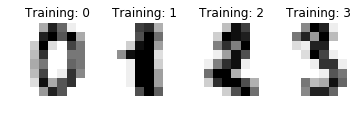

In [23]:
#Let's visualizate the digits (the first n digits)
n = 4
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:n]):
    plt.subplot(1, n, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label) 

In [24]:
#Reshaping the images (seeing the image as vector of length equal to the total amount of pixels)
data = digits.images.reshape((n_samples, -1))
data.shape

(1797, 64)

In [27]:
#Standardize the Dataset
scaler = preprocessing.StandardScaler()
normalized_data = scaler.fit_transform(data)

In [32]:
#Division of the dataset in train and test
digits_train, digits_test, labels_train, labels_test = train_test_split(normalized_data, digits.target,
                                                                        test_size=0.30, random_state=1608)

In this article https://www.pyimagesearch.com/2018/10/08/keras-vs-tensorflow-which-one-is-better-and-which-one-should-i-learn/, It is explained that the best way to proceed is to use Keras with Tensorflow. So, I'll be using Keras inside Tensorflow.

In [ ]:
#Fijamos una semilla
tf.set_random_seed(1234)

#se pueden imprimir los resultados cada ciertas epocas, por ello abrimos una sesión:
sess=tf.Session()

#iniciamos una sesion de tensor flow todo con el fin de hacer calculos de eficacia a traves de
#las epocas de aprendizaje

sess.run(tf.global_variables_initializer())

for i in range(401):
    _, accuracy_val=sess.run([train_opt,accuracy],
                            feed_dict= {
                                x:images30,
                                y:list(labels)
                            })
    _, loss_val=sess.run([train_opt,loss],
                            feed_dict= {
                                x:images30,
                                y:list(labels)
                            })
    if i%40==0:
        print("EPOCH",i)
        print("Eficacia: ",accuracy_val)
        print("Pérdidas:",loss_val)
    #print("Fin del Ecpoh ", i)